In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [4]:
img_width, img_height = 224, 224
batchsize = 32
epochs = 20
num_of_class = 2

train = keras.utils.image_dataset_from_directory(
    directory='chest_xray/chest_xray/train',
    labels='inferred',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras.utils.image_dataset_from_directory(
    directory='chest_xray/chest_xray/val',
    labels='inferred',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras.utils.image_dataset_from_directory(
    directory='chest_xray/chest_xray/test',
    labels='inferred',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [5]:
train.class_names

['NORMAL', 'PNEUMONIA']

In [6]:
# Load and preprocess the data using the datasets
def preprocess_data(dataset):
    x = []
    y = []
    for feature, label in dataset:
        x.append(feature)
        y.append(label)
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    x = x / 255.0  # Normalize the images
    return x, y


x_train, y_train = preprocess_data(train)
x_val, y_val = preprocess_data(validation)
x_test, y_test = preprocess_data(test)

In [7]:
import torch
device = torch.device("mps" if torch.ones(1, device="mps") else "cpu")
print(device)

mps


In [5]:
# Load the VGG16 model with weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(2, activation='softmax')(x)

model = keras.Model(base_model.input, x)

# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
es = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/20


2023-10-23 17:02:32.435857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 34s 198ms/step - loss: 2.4066 - accuracy: 0.8840 - val_loss: 1.5732 - val_accuracy: 0.6875
Epoch 2/20
163/163 [==============================] - 31s 189ms/step - loss: 0.2454 - accuracy: 0.9594 - val_loss: 0.4408 - val_accuracy: 0.9375
Epoch 3/20
163/163 [==============================] - 31s 193ms/step - loss: 0.2724 - accuracy: 0.9559 - val_loss: 0.4263 - val_accuracy: 0.9375
Epoch 4/20
163/163 [==============================] - 31s 188ms/step - loss: 0.1218 - accuracy: 0.9778 - val_loss: 0.3645 - val_accuracy: 0.9375
Epoch 5/20
163/163 [==============================] - 31s 188ms/step - loss: 0.1665 - accuracy: 0.9743 - val_loss: 0.4417 - val_accuracy: 0.9375


In [8]:
eval_results = model.evaluate(x_test, y_test)

20/20 [==============================] - 4s 177ms/step - loss: 1.5748 - accuracy: 0.8397


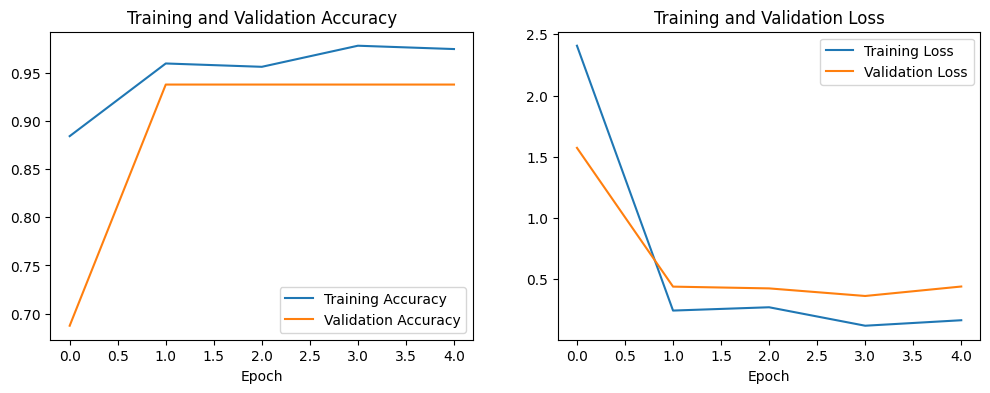

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')

plt.show()

In [10]:
model.save('model/pneumonia_cnn_model1.h5')

/Users/sundar/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from tensorflow import keras
import numpy as np
loaded_model = keras.models.load_model('model/pneumonia_cnn_model1.h5')
img_width, img_height = 224, 224
batchsize = 32
epochs = 20
num_of_class = 2


user_image_path = '/Users/sundar/Projects/Skin-cancer/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0283-0001.jpeg'
user_image = keras.preprocessing.image.load_img(
    user_image_path, target_size=(img_width, img_height))
user_image = keras.preprocessing.image.img_to_array(user_image)
user_image = user_image / 255.0
user_image = np.expand_dims(user_image, axis=0)

predictions = loaded_model.predict(user_image)

if predictions[0][0] > predictions[0][1]:
    print("The X-ray is classified as NORMAL.")
else:
    print("The X-ray is classified as PNEUMONIA.")

1/1 [==============================] - 1s 662ms/step
The X-ray is classified as PNEUMONIA.


In [8]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model = tf.keras.models.load_model('./model/pneumonia_cnn_model.h5')
print(test)

y_true = []
y_pred = []

for batch in test:
    images, labels = batch
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1).tolist()

    y_true.extend(labels.numpy().tolist())
    y_pred.extend(predicted_labels)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

target_names = ['NORMAL', 'PNEUMONIA']
report = classification_report(y_true, y_pred, target_names=target_names)

print("Classification Report:")
print(report)

# Additionally, you can print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


2023-11-03 17:18:53.162270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 737ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.29      0.45       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.83      0.64      0.64       624
weighted avg       0.80      0.73      0.68       624


Confusion Matrix:
[[ 69 165]
 [  3 387]]


Text(50.722222222222214, 0.5, 'Actual Value')

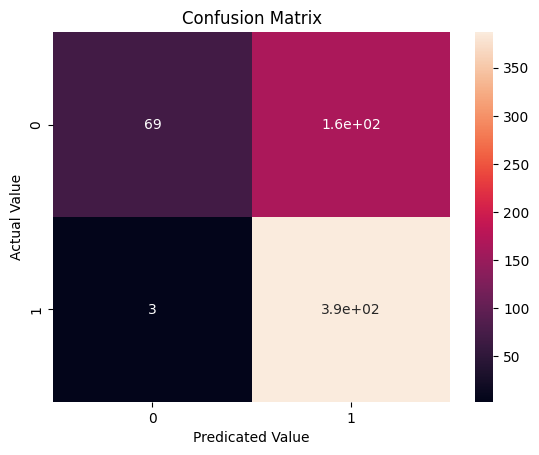

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicated Value")
plt.ylabel("Actual Value")